In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import sys
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

from scipy.ndimage import rotate

## Outstanding Questions

1. What transformations should we apply to CIFAR-10 clean data?

## Obtain CIFAR-10 Clean Data

In [2]:
# PARAMS
batch_size = 256

In [31]:
# TODO: should we apply the below transformations?
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

transform_image = transforms.ToPILImage()

In [32]:
print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(root='../00_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified


/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [99]:
def apply_patch_to_img(img_index, patch_path = '../00_data/patches/toaster_patch.png', h = 'center', v = 'center', ratio = 3):
    """A helper function to apply a patch to a CIFAR-10 image given an index in the training / test set.
    
    Args:
        img_index (int): the index of the image in the training / test set
        patch_path (str): the path to the patch image
        h (str): the horizontal position of the patch (default: 'center') - see mode_to_value keys for possible values
        v (str): the vertical position of the patch (default: 'center') - see mode_to_value keys for possible values
        ratio (int): the ratio of the patch size to the image size (default: 3). 

    Returns:
        img (PIL): the image with the patch applied
    
    """

    image = transform_image(trainset[img_index][0])
    
    patch_image = Image.open(patch_path)
    patch_image = patch_image.resize((image.width // ratio, image.height // ratio), Image.Resampling.LANCZOS)

    # map from mode value to a function that returns the correct value position
    mode_to_value = {
        'left': lambda width, path: 0,
        'center_h': lambda width, path: width // 2 - path.width // 2,
        'center_v': lambda height, path: height // 2 - path.height // 2, 
        'right': lambda width, path: width - path.width,
        'up': lambda height, path: 0,
        'down': lambda height, path: height - path.height,
    }

    plt.figure(figsize=(2.5, 2.5))
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')  
    plt.show()
    

    x = mode_to_value[h if h != 'center' else 'center_h'](image.width, patch_image)
    y = mode_to_value[v if v != 'center' else 'center_v'](image.height, patch_image)

    print(f"Patch will be placed {h}-{v}")

    image.paste(patch_image, (x, y), mask = patch_image)
    
    plt.figure(figsize=(2.5, 2.5))
    plt.title("Patched")
    plt.imshow(image)
    plt.axis('off')
    plt.show()


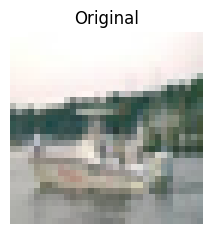

Patch will be placed center-center


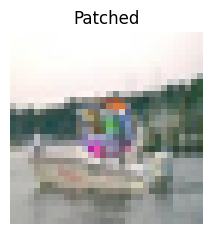

In [100]:
apply_patch_to_img(240)

## Create Patch - test - IGNORE THIS CELL


In [62]:
h = 'right'
v = 'center'
ratio = 3

PATCH_PATH = '../00_data/patches/toaster_patch.png'
src_img = '../00_data/test_images/banana.jpeg'
save_path = '../00_data/test_images/banana-patched.jpeg'

mode = {
    'h': h,
    'v': v
}

print(f"Path will be placed {mode['h']}-{mode['v']}")

# map from mode value to a function that returns the correct value position
mode_to_value = {
    'left': lambda width, path: 0,
    'center_h': lambda width, path: width // 2 - path.width // 2,
    'center_v': lambda height, path: height // 2 - path.height // 2,
    'right': lambda width, path: width - path.width,
    'up': lambda height, path: 0,
    'down': lambda height, path: height - path.height,
}

def get_position(mode, image, path):
    x = mode_to_value[mode['h'] if mode['h'] != 'center' else 'center_h'](image.width, path)
    y = mode_to_value[mode['v'] if mode['v'] != 'center' else 'center_v'](image.height, path)
    return x, y

patch_image = Image.open(PATCH_PATH)
src_image = Image.open(src_img)

patch_image = patch_image.resize((src_image.width // ratio, src_image.height // ratio), Image.Resampling.LANCZOS)
position = get_position(mode, src_image, patch_image)

src_image.paste(patch_image, position, mask = patch_image)
src_image.save(save_path)

print(f"Image saved at: {save_path}")

Path will be placed right-center
Image saved at: ../00_data/test_images/banana-patched.jpeg
